In [1]:
from IPython.display import clear_output
!pip install opensimplex
!pip install noise
clear_output()

In [44]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from tqdm import tqdm
from opensimplex import OpenSimplex
from skimage.filters import threshold_otsu
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

from scipy.ndimage import zoom
from noise import snoise2
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim
import random


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


np.random.seed(42)

cuda


In [4]:
class XIT2Dataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256), noise_type=None):
        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.noise_type = noise_type
        self.image_paths = self._load_image_paths()
    
    def _load_image_paths(self):
        image_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith(".png"):
                    image_paths.append(os.path.join(root, file))
        return sorted(image_paths)
    
    def __len__(self):
        return len(self.image_paths)

    def set_noise_type(self, noise_type):
        self.noise_type = noise_type
    
    def _add_coarse_noise(self, image_tensor):
        """Apply coarse noise."""
        batch_size, height, width = image_tensor.shape
        coarse_resolution = (16, 16)
        # Generate coarse Gaussian noise
        noise = torch.normal(mean=0.0, std=0.2, size=(batch_size, *coarse_resolution), device=image_tensor.device)
        # Upsample noise to match target size
        noise = torch.nn.functional.interpolate(noise.unsqueeze(1), size=(height, width), mode='bilinear', align_corners=False)
        noise = noise.squeeze(1)
        return torch.clamp(image_tensor + noise, -1, 1)

    def _add_simplex_noise(self, image_tensor):
        """Apply simplex noise with forward diffusion."""
        batch_size, height, width = image_tensor.shape
        frequency = 2 ** -6
        octaves = 6
        persistence = 0.8
        lacunarity = 2.0
        diffusion_steps = 87

        # Generate multi-octave noise
        coords_x = torch.linspace(0, width, steps=width, device=image_tensor.device).repeat(height, 1).T
        coords_y = torch.linspace(0, height, steps=height, device=image_tensor.device).repeat(width, 1)
        noise = torch.zeros((batch_size, height, width), device=image_tensor.device)

        for octave in range(octaves):
            freq = frequency * (lacunarity ** octave)
            noise += persistence ** octave * torch.sin(freq * (coords_x + coords_y))

        # Normalize noise to [0, 1]
        noise = (noise - noise.min()) / (noise.max() - noise.min())

        # Forward diffusion process
        for _ in range(diffusion_steps):
            image_tensor = torch.clamp(image_tensor + noise * (1 / diffusion_steps), -1, 1)

        return image_tensor

    def _add_noise(self, image_tensor):
        if self.noise_type == "coarse":
            return self._add_coarse_noise(image_tensor)
        elif self.noise_type == "simplex":
            return self._add_simplex_noise(image_tensor)
        return image_tensor
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")  # Load as grayscale
        image = self.transform(image)
        if self.noise_type:
            image = self._add_noise(image)
        label = torch.tensor(0, dtype=torch.long)  # Healthy label
        return image, label

    def plot_samples(self, idx, num_samples=8, label_title='Healthy'):
        if num_samples % 4 != 0:
            raise ValueError("Number of samples must be a multiple of 4.")
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 10))
        for i in range(num_samples):
            # idx = np.random.randint(len(self.image_paths))
            image, label = self[idx]
            print(f"Image range: {image.min().item()} to {image.max().item()}")
            image_np = image.squeeze(0).numpy()
            axes[i].imshow(image_np, cmap='gray')
            axes[i].set_title(f"Label: {label_title}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

Image range: -1.0 to 1.0
Image range: -1.0 to 1.0
Image range: -1.0 to 1.0
Image range: -1.0 to 1.0


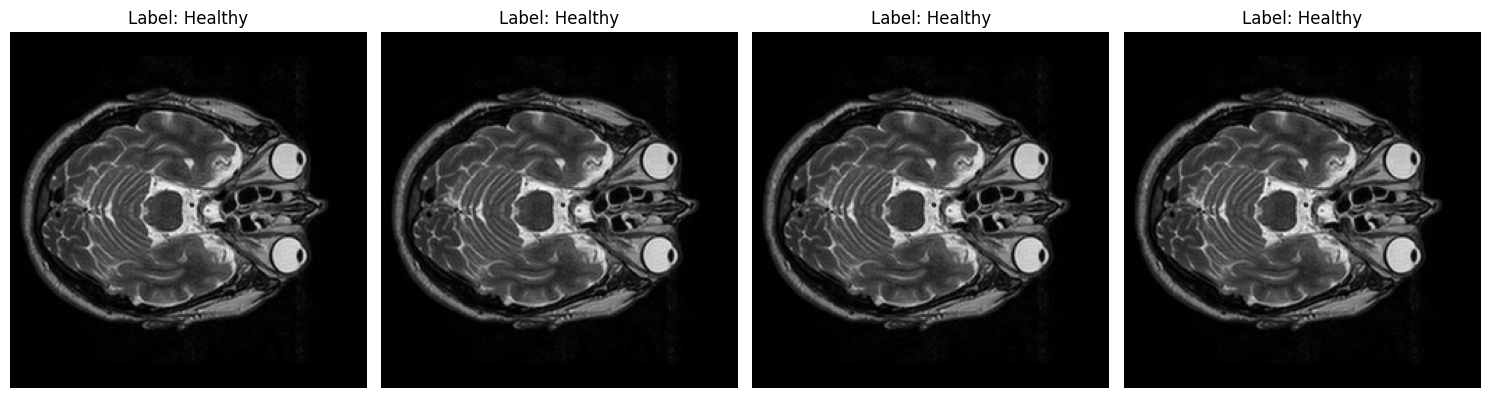

Image range: -1.0 to 1.0
Image range: -1.0 to 1.0
Image range: -1.0 to 1.0
Image range: -1.0 to 1.0


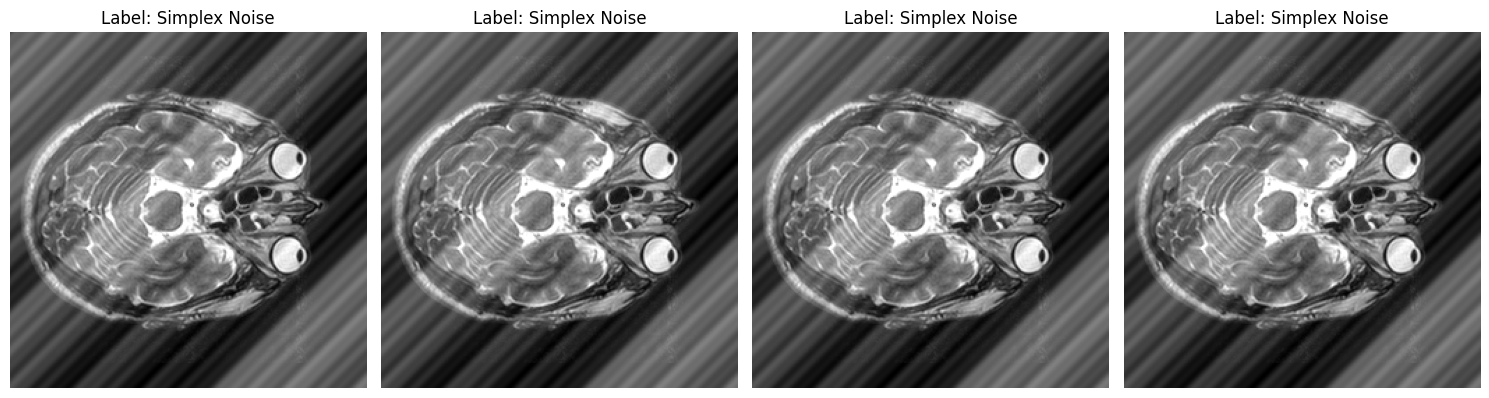

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

ixit1 = XIT2Dataset("/kaggle/input/ixit2-slices", transform)
idx = np.random.randint(len(ixit1.image_paths))
ixit1.plot_samples(idx, 4, label_title='Healthy')
ixit1.set_noise_type("simplex")
ixit1.plot_samples(idx, 4, label_title='Simplex Noise')

Image range: -1.0 to 1.0
Image range: -1.0 to 1.0
Image range: -1.0 to 1.0
Image range: -1.0 to 1.0


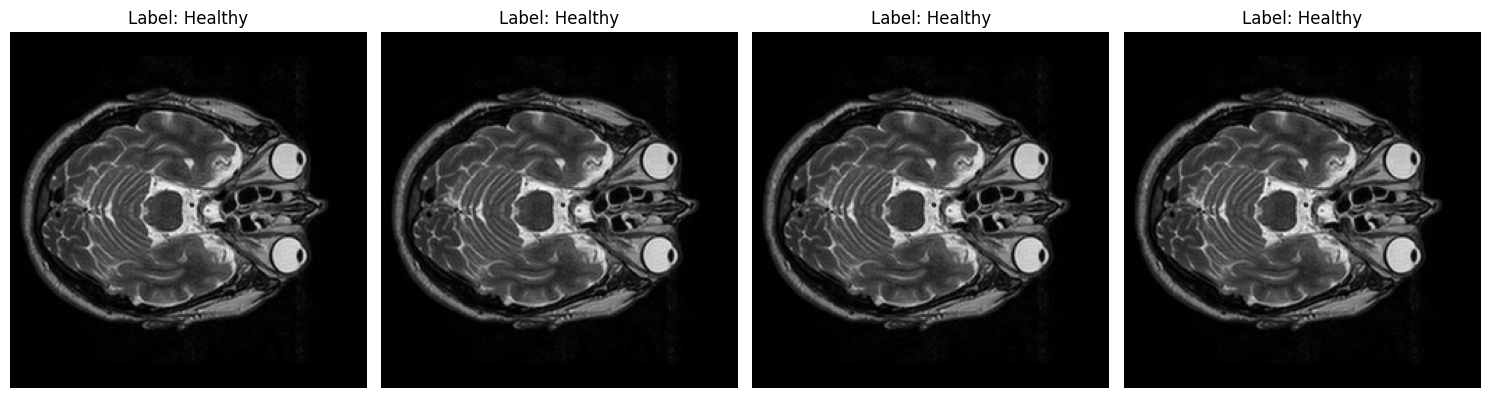

Image range: -1.0 to 1.0
Image range: -1.0 to 1.0
Image range: -1.0 to 1.0
Image range: -1.0 to 1.0


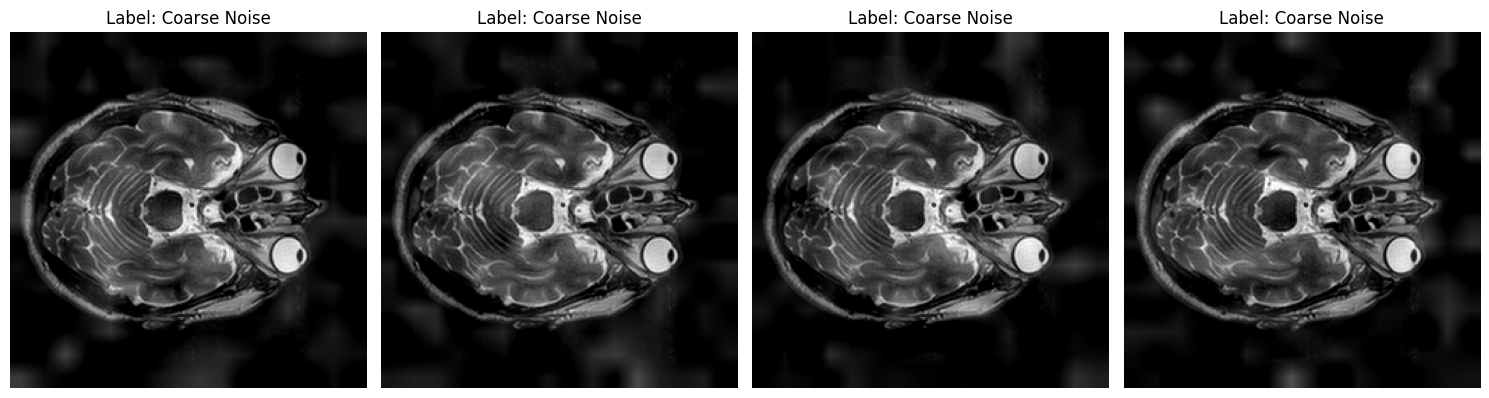

In [6]:
ixit2 = XIT2Dataset("/kaggle/input/ixit2-slices", transform)
ixit2.plot_samples(idx, 4, label_title='Healthy')
ixit2.set_noise_type("coarse")
ixit2.plot_samples(idx, 4, label_title='Coarse Noise')

In [7]:
# class VAE(nn.Module):
#     def __init__(self, input_channels=1, latent_dim=128):
#         super(VAE, self).__init__()
#         self.latent_dim = latent_dim

#         self.encoder = nn.Sequential(
#             nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # 128x128
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),              # 64x64
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),             # 32x32
#             nn.ReLU(),
#             nn.Flatten()
#         )
#         self.fc_mu = nn.Linear(128 * 32 * 32, latent_dim)  # Latent space mean
#         self.fc_logvar = nn.Linear(128 * 32 * 32, latent_dim)  # Latent space log variance

#         self.fc_decoder = nn.Linear(latent_dim, 128 * 32 * 32)
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64x64
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 128x128
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),  # 256x256
#             nn.Sigmoid()
#         )

#     def reparameterize(self, mu, logvar):
#         """Reparameterization trick for sampling."""
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         # Encode
#         z = self.encoder(x)
#         mu = self.fc_mu(z)
#         logvar = self.fc_logvar(z)
#         # Sample latent vector
#         z_sampled = self.reparameterize(mu, logvar)
#         # Decode
#         z_decoded = self.fc_decoder(z_sampled)
#         z_decoded = z_decoded.view(-1, 128, 32, 32)
#         reconstruction = self.decoder(z_decoded)
#         return reconstruction, mu, logvar

# # Loss function
# def vae_loss_function(reconstruction, input, mu, logvar):
#     # Reconstruction loss
#     reconstruction_loss = nn.MSELoss()(reconstruction, input)
#     # KL Divergence
#     kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return reconstruction_loss + kl_divergence / input.size(0), reconstruction_loss, kl_divergence

# def train_vae(vae, train_loader, optimizer, num_epochs=20):
#     vae.train()
#     train_losses = []
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
#             for batch_idx, (images, _) in enumerate(train_loader):
#                 images = images.to(device)
#                 optimizer.zero_grad()
#                 reconstruction, mu, logvar = vae(images)
#                 loss, recon_loss, kl_loss = vae_loss_function(reconstruction, images, mu, logvar)
#                 loss.backward()
#                 optimizer.step()
#                 epoch_loss += loss.item()
#                 tepoch.set_postfix(loss=loss.item())
#                 tepoch.update(1)
#         epoch_loss /= len(train_loader)
#         train_losses.append(epoch_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
#     return train_losses

# def plot_loss(train_losses):
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_losses, label='Training Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training Loss over Epochs')
#     plt.legend()
#     plt.show()

In [8]:
# Hyperparameters
batch_size = 16
latent_dim = 128
learning_rate = 1e-4
num_epochs = 20

ixit1.set_noise_type(None)
train_loader = DataLoader(ixit1, batch_size=batch_size, shuffle=True)

In [9]:
# vae = VAE(input_channels=1, latent_dim=latent_dim).to(device)
# optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# train_losses = train_vae(vae, train_loader, optimizer, 3)

In [10]:
class BraTSDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256, 256)):
        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        self.image_paths, self.mask_paths = self._load_paths()
    
    def _load_paths(self):
        image_paths = []
        mask_paths = []
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.endswith("_t2.nii"):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root, file.replace("_t2.nii", "_seg.nii")))
        return sorted(image_paths), sorted(mask_paths)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()
        
        # Extract the middle slice along the z-axis
        z_index = image.shape[-1] // 2
        image = image[:, :, z_index]  # Extract 2D slice
        mask = mask[:, :, z_index]   # Extract 2D slice
    
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = resize(image, self.target_size, order=1, mode='reflect', anti_aliasing=True)
        mask = resize(mask, self.target_size, order=0, mode='reflect', anti_aliasing=False)
    
        # Convert NumPy arrays back to PIL images for transformation
        image = Image.fromarray((image * 255).astype(np.uint8))
        mask = Image.fromarray((mask * 255).astype(np.uint8))
    
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else: # Convert to tensors
            image = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0)  # Add channel dim
            mask = torch.tensor(np.array(mask), dtype=torch.float32)
    
        return image, mask

    def plot_samples(self, num_samples=4):
        if num_samples % 2 != 0:
            raise ValueError("Number of samples must be even.")        
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
        for i in range(num_samples):
            idx = np.random.randint(len(self.image_paths))
            image, mask = self[idx]
            image_np = image.squeeze(0).numpy() if isinstance(image, torch.Tensor) else image
            mask_np = mask.squeeze(0).numpy() if len(mask.shape) == 3 else mask
            axes[0, i].imshow(image_np, cmap='gray')
            axes[0, i].set_title("T2 Image")
            axes[0, i].axis('off')
            axes[1, i].imshow(mask_np, cmap='gray')
            axes[1, i].set_title("Segmentation Mask")
            axes[1, i].axis('off')
        plt.tight_layout()
        plt.show()

In [11]:
def dice_coefficient(predicted_mask, ground_truth_mask):
    smooth = 1e-6  # To avoid division by zero
    predicted_mask = predicted_mask.flatten()
    ground_truth_mask = ground_truth_mask.flatten()
    intersection = (predicted_mask * ground_truth_mask).sum()
    return (2. * intersection + smooth) / (predicted_mask.sum() + ground_truth_mask.sum() + smooth)


In [39]:
def plot_random_results_vae(vae, dataset, threshold=0.5, num_samples=4):
    vae.eval()
    dice_scores = []
    
    # Randomly sample indices
    random_indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in random_indices:
        image, ground_truth_mask = dataset[idx]
        image = image.to(device).unsqueeze(0)  # Add batch dimension

        # VAE reconstruction
        with torch.no_grad():
            reconstruction, _, _و _ = vae(image)
        
        # Residual calculation
        residual = torch.abs(image - reconstruction)  # Shape: (1, 1, 256, 256)
        
        # Predicted mask from residual
        predicted_mask = (residual > threshold).float()  # Binary mask
        
        # Dice coefficient
        # dice = dice_coefficient(
        #     predicted_mask.squeeze().cpu().numpy(),  # Convert to 2D NumPy
        #     ground_truth_mask.numpy()
        # )
        # dice_scores.append(dice)

        # Visualization for each random sample
        plt.figure(figsize=(20, 5))
        
        # Original Image
        plt.subplot(1, 5, 1)
        plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Original Image")
        plt.axis('off')
        
        # Reconstructed Image
        plt.subplot(1, 5, 2)
        plt.imshow(reconstruction.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Reconstructed Image")
        plt.axis('off')
        
        # Residual Image
        plt.subplot(1, 5, 3)
        plt.imshow(residual.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Residual Image")
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(1, 5, 4)
        plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Predicted Mask")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(1, 5, 5)
        plt.imshow(ground_truth_mask.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    # Overall Dice Score
    # avg_dice_score = sum(dice_scores) / len(dice_scores)
    # print(f"Average Dice Score: {avg_dice_score:.4f}")


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<ipython-input-39-2d4a35bae05f>, line 14)

In [13]:
# Assuming the dataset and trained VAE are loaded
data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
brats_dataset = BraTSDataset(data_dir=data_dir, transform=transform)

# Evaluate VAE with random sample plotting
# evaluate_vae(vae, brats_dataset, threshold=0.5, num_samples=10)


In [14]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

In [15]:
# ixit = XIT2Dataset("/kaggle/input/ixit2-slices", transform)
# ixit.plot_samples(4)

In [16]:
# data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
# dataset = BraTSDataset(data_dir=data_dir, transform=transform)

In [17]:
# dataset.plot_samples()

In [18]:
# class Encoder(nn.Module):
#     def __init__(self, latent_dim):
#         super(Encoder, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
#             nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
#             nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
#             nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
#         )
#         self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim)
#         self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dim)

#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(x.size(0), -1)
#         mu = self.fc_mu(x)
#         logvar = self.fc_logvar(x)
#         return mu, logvar

# class Decoder(nn.Module):
#     def __init__(self, latent_dim):
#         super(Decoder, self).__init__()
#         self.fc = nn.Linear(latent_dim, 256 * 16 * 16)
#         self.deconv = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
#             nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Tanh()
#         )

#     def forward(self, z):
#         x = self.fc(z)
#         x = x.view(x.size(0), 256, 16, 16)
#         x = self.deconv(x)
#         return x

In [19]:
# class TriVAE(nn.Module):
#     def __init__(self, latent_dim):
#         super(TriVAE, self).__init__()
#         self.encoder = Encoder(latent_dim)
#         self.decoder = Decoder(latent_dim)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         z = self.reparameterize(mu, logvar)
#         recon_x = self.decoder(z)
#         return recon_x, mu, logvar

In [20]:
# def vae_loss(recon_x, x, mu, logvar):
#     recon_loss = nn.L1Loss()(recon_x, x)
#     kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + kld_loss

# def triplet_loss(anchor, positive, negative, margin=1.0):
#     dist_pos = torch.norm(anchor - positive, p=2, dim=1)
#     dist_neg = torch.norm(anchor - negative, p=2, dim=1)
#     return torch.mean(torch.relu(dist_pos - dist_neg + margin))

In [21]:
# def apply_noise(noise_type, images):
#     if noise_type == 'coarse':
#         # Generate coarse noise directly in PyTorch
#         noise = torch.randn((images.size(0), 1, 32, 32), device=device) * 0.2  # Low-res Gaussian noise
#         noise = torch.nn.functional.interpolate(noise, size=images.shape[2:], mode='bilinear', align_corners=False)
#         return images + noise
#     elif noise_type == 'simplex':
#         # Generate simplex noise directly in PyTorch
#         simplex = OpenSimplex(seed=42)
#         scale = 1.0 / 64.0
#         noise = torch.zeros_like(images, device=device)
#         for i in range(images.size(2)):  # Height
#             for j in range(images.size(3)):  # Width
#                 noise[:, :, i, j] = torch.tensor([simplex.noise2(i * scale, j * scale) for _ in range(images.size(0))], device=device)
#         return images + noise
#     else:
#         return images.clone()  # No noise

In [22]:
# def train(model, dataloader, optimizer, dataset, noise_type='coarse', epochs=10):
#     model.to(device)
#     model.train()
    
#     for epoch in range(epochs):
#         total_loss = 0
#         print(f"Epoch {epoch + 1}/{epochs}")
#         for images, _ in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}"):
#             images = images.to(device)
#             # Generate anchor, positive, and negative samples
#             anchor = images
#             positive = images.clone()
#             # Add noise to negative samples explicitly
#             negative = apply_noise(noise_type, images) 
#             optimizer.zero_grad()
#             # Forward pass for each sample
#             recon_anchor, mu_anchor, logvar_anchor = model(anchor)
#             recon_positive, mu_positive, logvar_positive = model(positive)
#             recon_negative, mu_negative, logvar_negative = model(negative)
#             # Compute losses
#             vae_loss_anchor = vae_loss(recon_anchor, anchor, mu_anchor, logvar_anchor)
#             vae_loss_positive = vae_loss(recon_positive, positive, mu_positive, logvar_positive)
#             vae_loss_negative = vae_loss(recon_negative, negative, mu_negative, logvar_negative)
#             t_loss = triplet_loss(mu_anchor, mu_positive, mu_negative)
#             # Combine losses
#             loss = vae_loss_anchor + vae_loss_positive + vae_loss_negative + t_loss
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
        
#         print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {total_loss / len(dataloader):.4f}")
#     torch.save(model.state_dict(), 'model_final.pth') 
#     print("Model saved!")

# def evaluate(model, dataloader):
#     model.eval()
#     residual_maps = []
#     with torch.no_grad():
#         for images, _ in tqdm(dataloader, desc="Evaluating"):
#             images = images.to(device)
#             recon_images, _, _ = model(images)
#             residual_map = torch.abs(images - recon_images).cpu().numpy()
#             residual_maps.append(residual_map)
#     return np.concatenate(residual_maps)

In [23]:
# train_loader = DataLoader(ixit, batch_size=128, shuffle=True)

In [24]:
# latent_dim = 512
# model = TriVAE(latent_dim)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [25]:
# train(model, train_loader, optimizer, ixit, noise_type='coarse', epochs=20)

In [26]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.filters import threshold_otsu

# def evaluate_and_visualize(model, dataset, device, num_samples=4):
#     """
#     Evaluate the model on BraTS slices, compute Dice score, and visualize results.
    
#     Args:
#         model (nn.Module): Trained Tri-VAE model.
#         dataset (Dataset): BraTSDataset instance.
#         device (torch.device): Device to run the model on (CPU or GPU).
#         num_samples (int): Number of slices to evaluate and visualize.
#     """
#     model.to(device)
#     model.eval()

#     fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
#     dice_scores = []

#     with torch.no_grad():
#         for i in range(num_samples):
#             # Randomly select a tumor slice
#             idx = np.random.randint(len(dataset))
#             image, mask = dataset[idx]
#             image = image.to(device).unsqueeze(0)  # Add batch dimension

#             # Forward pass through the model
#             recon_image, _, _ = model(image)
#             residual_map = torch.abs(image - recon_image).squeeze(0).cpu().numpy()

#             # Threshold residual map to identify tumor region
#             threshold = threshold_otsu(residual_map)
#             predicted_mask = (residual_map > threshold).astype(np.uint8)

#             # Compute Dice score
#             ground_truth = mask.numpy().astype(np.uint8)
#             intersection = np.sum(predicted_mask * ground_truth)
#             dice = (2.0 * intersection) / (np.sum(predicted_mask) + np.sum(ground_truth) + 1e-6)
#             dice_scores.append(dice)

#             # Visualize results
#             axes[i, 0].imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
#             axes[i, 0].set_title("Input Slice")
#             axes[i, 0].axis('off')

#             axes[i, 1].imshow(recon_image.squeeze(0).cpu().numpy(), cmap='gray')
#             axes[i, 1].set_title("Reconstructed Slice")
#             axes[i, 1].axis('off')

#             axes[i, 2].imshow(residual_map, cmap='hot')
#             axes[i, 2].set_title("Residual Map")
#             axes[i, 2].axis('off')

#             axes[i, 3].imshow(ground_truth, cmap='gray', alpha=0.5, label='Ground Truth')
#             axes[i, 3].imshow(predicted_mask, cmap='jet', alpha=0.5, label='Predicted Mask')
#             axes[i, 3].set_title(f"Tumor Prediction (Dice: {dice:.4f})")
#             axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()

#     print(f"Average Dice Score: {np.mean(dice_scores):.4f}")

In [27]:
# brats_dataset = BraTSDataset(
#     data_dir=data_dir,
#     transform=transforms.Compose([transforms.ToTensor()]),
#     target_size=(256, 256)
# )

# # Evaluate and visualize
# evaluate_and_visualize(model, brats_dataset, device, num_samples=4)

In [28]:
# def evaluate_brats(model, dataset, num_patients=100, threshold=0.1, num_samples_to_display=5):
#     """ Evaluate the trained Tri-VAE model on BraTS tumor slices and compute Dice scores """
#     model.to(device)
#     model.eval()
    
#     dice_scores = []
#     samples_to_display = []    
#     with torch.no_grad():
#         for idx in range(min(num_patients, len(dataset))):
#             image, mask = dataset[idx]
#             image = image.to(device).unsqueeze(0)  # Add batch dimension
#             # Forward pass through the model
#             recon_image, _, _ = model(image)
#             residual_map = torch.abs(image - recon_image).squeeze(0).cpu().numpy()            
#             # Threshold residual map to identify tumor region
#             predicted_mask = (residual_map > threshold).astype(np.uint8)
            
#             ground_truth = mask.numpy().astype(np.uint8)
#             intersection = np.sum(predicted_mask * ground_truth)
#             dice = (2.0 * intersection) / (np.sum(predicted_mask) + np.sum(ground_truth) + 1e-6)
#             dice_scores.append(dice)
#             if len(samples_to_display) < num_samples_to_display:
#                 samples_to_display.append((image.squeeze(0).cpu().numpy(), residual_map, predicted_mask, ground_truth))
    
#     visualize_results(samples_to_display, dice_scores[:num_samples_to_display])
#     return np.mean(dice_scores)

# def visualize_results(samples, dice_scores):
#     """ Visualize input slices, residual maps, predicted masks, and ground truth masks """
#     num_samples = len(samples)
#     fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
#     for i, (input_slice, residual_map, predicted_mask, ground_truth) in enumerate(samples):
#         input_slice = input_slice.squeeze()
#         residual_map = residual_map.squeeze()
#         predicted_mask = predicted_mask.squeeze()
#         ground_truth = ground_truth.squeeze()
#         axes[i, 0].imshow(input_slice, cmap='gray')
#         axes[i, 0].set_title("Input Slice")
#         axes[i, 0].axis('off')
#         axes[i, 1].imshow(residual_map, cmap='hot')
#         axes[i, 1].set_title("Residual Map")
#         axes[i, 1].axis('off')
#         axes[i, 2].imshow(predicted_mask, cmap='gray', alpha=1)
#         axes[i, 2].set_title(f"Predicted Mask (Dice: {dice_scores[i]:.4f})")
#         axes[i, 2].axis('off')
#         axes[i, 3].imshow(ground_truth, cmap='gray', alpha=1)
#         axes[i, 3].set_title("Ground Truth Mask")
#         axes[i, 3].axis('off')
#     plt.tight_layout()
#     plt.show()

In [29]:
# brats_dataset = BraTSDataset(
#     data_dir=data_dir,
#     transform=transforms.Compose([transforms.ToTensor()]),
#     target_size=(256, 256)
# )
# average_dice = evaluate_brats(model, brats_dataset, num_patients=100, threshold=0.1, num_samples_to_display=10)
# print(f"Average Dice Score: {average_dice:.4f}")

In [30]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [31]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.GroupNorm(8, out_channels)
        self.activation = nn.SiLU()

    def forward(self, x):
        return self.activation(self.norm(self.conv(x)))

In [32]:
class FeatureInteractionModule(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, reduction_ratio=4):
        super(FeatureInteractionModule, self).__init__()
        reduced_channels = encoder_channels // reduction_ratio
        
        # 1x1 convolution for reducing the channels of encoder and decoder features
        self.encoder_conv = nn.Conv2d(encoder_channels, reduced_channels, kernel_size=1)
        self.decoder_conv = nn.Conv2d(decoder_channels, reduced_channels, kernel_size=1)
        
        # Activation and scaling layers
        self.tanh = nn.Tanh()
        self.alpha = nn.Parameter(torch.ones(1))
        self.beta = nn.Parameter(torch.ones(1))
    
    def forward(self, encoder_features, decoder_features):
        # Reduce channel dimensions
        reduced_encoder = self.encoder_conv(encoder_features)
        reduced_decoder = self.decoder_conv(decoder_features)
        
        # Element-wise multiplication and addition
        tanh_output = self.tanh(reduced_encoder * reduced_decoder)
        x = tanh_output * reduced_encoder
        output = self.alpha * x + self.beta * reduced_encoder
        
        return output

In [33]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.el1conv1 = ConvBlock(1, 16)
        self.el1conv2 = ConvBlock(16, 16)
        self.el1avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el2conv1 = ConvBlock(16, 32)
        self.el2conv2 = ConvBlock(32, 32)
        self.el2avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el3conv1 = ConvBlock(32, 64)
        self.el3conv2 = ConvBlock(64, 64)
        self.el3avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el4conv1 = ConvBlock(64, 128)
        self.el4conv2 = ConvBlock(128, 128)
        self.el4avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el5conv1 = ConvBlock(128, 256)
        self.el5conv2 = ConvBlock(256, 256)
        self.el5avgpool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.el6conv1 = ConvBlock(256, 512)
        self.el6conv2 = ConvBlock(512, 512)

        # Bottleneck
        self.fc_mu = nn.Linear(512 * 8 * 8, 1024)
        self.fc_logvar = nn.Linear(512 * 8 * 8, 1024)
        self.fc_decode = nn.Linear(1024, 512 * 8 * 8)

        # Decoder
        self.dl6upconv =  nn.ConvTranspose2d(1024, 256, kernel_size=2, stride=2)       
        
        self.dl5conv1 = ConvBlock(256, 256)
        self.dl5conv2 = ConvBlock(256, 256)
        self.dl5upconv =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)

        self.dl4conv1 = ConvBlock(128, 128)
        self.dl4conv2 = ConvBlock(128, 128)
        self.dl4conv3 = ConvBlock(128, 128)
        self.dl4conv4 = ConvBlock(128, 128)
        self.dl4conv5 = nn.Conv2d(128, 1, 1, 1, 0)
        self.dl4upconv =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dl3conv1 = ConvBlock(80, 64)
        self.dl3conv2 = ConvBlock(64, 64)
        self.dl3upconv =  nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        self.dl2conv1 = ConvBlock(64, 32)
        self.dl2conv2 = ConvBlock(32, 32)
        self.dl2upconv =  nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.dl1conv1 = ConvBlock(32, 16)
        self.dl1conv2 = ConvBlock(16, 16)
        self.dl1conv3 = nn.Conv2d(16, 1, 1, 1, 0)

        self.gcs = FeatureInteractionModule(64, 64)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        x = self.el1conv1(x)
        x = self.el1conv2(x)
        skip1 = x
        x = self.el1avgpool(x)

        x = self.el2conv1(x)
        x = self.el2conv2(x)
        skip2 = x
        x = self.el2avgpool(x)

        x = self.el3conv1(x)
        x = self.el3conv2(x)
        skip3 = x
        x = self.el3avgpool(x)

        x = self.el4conv1(x)
        x = self.el4conv2(x)
        x = self.el4avgpool(x)

        x = self.el5conv1(x)
        x = self.el5conv2(x)
        x = self.el5avgpool(x)

        x = self.el6conv1(x)
        x = self.el6conv2(x)
        skip4 = x

        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z)
        x = x.view(x.size(0), 512, 8, 8)
        # torch.cat([x, skips[3]], dim=1)
        # print(f'skip4 shape is : {skip4.shape} and x shape is : {x.shape} and z shape is {z.shape}')
        
        x = self.dl6upconv(torch.cat([x, skip4], dim=1))

        x = self.dl5conv1(x)        
        x = self.dl5conv2(x)        
        x = self.dl5upconv(x)

        x = self.dl4conv1(x)
        x = self.dl4conv2(x)
        ux = self.dl4upconv(x)
        x = self.dl4conv3(x)
        x = self.dl4conv4(x)
        l4out = self.dl4conv5(x)

        gcs = self.gcs(skip3, ux)

        x = self.dl3conv1(torch.cat([gcs, ux], dim=1))
        x = self.dl3conv2(x)
        x = self.dl3upconv(x)

        x = self.dl2conv1(torch.cat([skip2, x], dim=1))
        x = self.dl2conv2(x)
        x = self.dl2upconv(x)

        x = self.dl1conv1(torch.cat([skip1, x], dim=1))
        x = self.dl1conv2(x)
        x = self.dl1conv3(x)
        
        return x, l4out, mu, logvar

In [34]:
def train_vae(model, dataloader, device, epochs=10, learning_rate=1e-4, alpha=1, beta=1):
    """
    Train the VAE model with a progress bar using tqdm.
    
    Args:
        model: The VAE model.
        dataloader: DataLoader object for training data.
        device: The device (CPU or GPU) to train on.
        epochs: Number of training epochs.
        learning_rate: Learning rate for the optimizer.
        alpha: Weight for L1 loss on the main output.
        beta: Weight for L1 loss on the intermediate (low-resolution) output.
        
    Returns:
        Training loss history.
    """
    # Define optimizer and loss functions
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    # Define helper functions for the loss components
    def kld_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.size(0)

    def ssim_loss(pred, target):
        return 1 - ssim(pred, target, data_range=1.0)

    model.to(device)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")

        for images, _ in progress_bar:  # Assuming labels are not used
            images = images.to(device)

            # Forward pass
            reconstructed, l4_out, mu, logvar = model(images)

            # Resize ground truth for intermediate L4 output
            l4_target = nn.functional.interpolate(images, size=(32, 32), mode='bilinear', align_corners=False)

            # Compute loss components
            l1_loss_main = nn.L1Loss()(reconstructed, images)
            l1_loss_l4 = nn.L1Loss()(l4_out, l4_target)
            kld = kld_loss(mu, logvar)
            ssim_value = ssim_loss(reconstructed, images)

            # Total loss
            total_loss = alpha * l1_loss_main + beta * l1_loss_l4 + kld + ssim_value

            # Backpropagation and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

            # Update progress bar description
            progress_bar.set_postfix({"Loss": total_loss.item()})

        # Store epoch loss
        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_epoch_loss)

        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}")

    return loss_history


In [35]:
vae = VAE().to(device)
train_losses = train_vae(vae, train_loader, device, epochs = 20)

Epoch 1/20:   0%|          | 0/1804 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
Epoch 1/20: 100%|██████████| 1804/1804 [06:01<00:00,  4.98batch/s, Loss=0.145] 


Epoch [1/20], Avg Loss: 0.7371


Epoch 2/20: 100%|██████████| 1804/1804 [04:42<00:00,  6.39batch/s, Loss=0.105] 


Epoch [2/20], Avg Loss: 0.1255


Epoch 3/20: 100%|██████████| 1804/1804 [04:42<00:00,  6.38batch/s, Loss=0.0997]


Epoch [3/20], Avg Loss: 0.1019


Epoch 4/20: 100%|██████████| 1804/1804 [04:42<00:00,  6.39batch/s, Loss=0.0835]


Epoch [4/20], Avg Loss: 0.0792


Epoch 5/20: 100%|██████████| 1804/1804 [04:41<00:00,  6.41batch/s, Loss=0.0596]


Epoch [5/20], Avg Loss: 0.0682


Epoch 6/20: 100%|██████████| 1804/1804 [04:40<00:00,  6.43batch/s, Loss=0.0573]


Epoch [6/20], Avg Loss: 0.0615


Epoch 7/20: 100%|██████████| 1804/1804 [04:39<00:00,  6.45batch/s, Loss=0.0618]


Epoch [7/20], Avg Loss: 0.0569


Epoch 8/20: 100%|██████████| 1804/1804 [04:43<00:00,  6.36batch/s, Loss=0.0584]


Epoch [8/20], Avg Loss: 0.0535


Epoch 9/20: 100%|██████████| 1804/1804 [04:41<00:00,  6.41batch/s, Loss=0.0434]


Epoch [9/20], Avg Loss: 0.0509


Epoch 10/20: 100%|██████████| 1804/1804 [04:41<00:00,  6.42batch/s, Loss=0.0402]


Epoch [10/20], Avg Loss: 0.0486


Epoch 11/20: 100%|██████████| 1804/1804 [04:42<00:00,  6.40batch/s, Loss=0.0528]


Epoch [11/20], Avg Loss: 0.0464


Epoch 12/20: 100%|██████████| 1804/1804 [04:41<00:00,  6.40batch/s, Loss=0.0375]


Epoch [12/20], Avg Loss: 0.0432


Epoch 13/20: 100%|██████████| 1804/1804 [04:45<00:00,  6.33batch/s, Loss=0.0335]


Epoch [13/20], Avg Loss: 0.0390


Epoch 14/20: 100%|██████████| 1804/1804 [04:43<00:00,  6.36batch/s, Loss=0.0342]


Epoch [14/20], Avg Loss: 0.0356


Epoch 15/20: 100%|██████████| 1804/1804 [04:41<00:00,  6.40batch/s, Loss=0.0345]


Epoch [15/20], Avg Loss: 0.0331


Epoch 16/20: 100%|██████████| 1804/1804 [04:40<00:00,  6.42batch/s, Loss=0.0361]


Epoch [16/20], Avg Loss: 0.0312


Epoch 17/20: 100%|██████████| 1804/1804 [04:39<00:00,  6.44batch/s, Loss=0.0345]


Epoch [17/20], Avg Loss: 0.0296


Epoch 18/20: 100%|██████████| 1804/1804 [04:41<00:00,  6.41batch/s, Loss=0.0248]


Epoch [18/20], Avg Loss: 0.0281


Epoch 19/20: 100%|██████████| 1804/1804 [04:42<00:00,  6.38batch/s, Loss=0.0235]


Epoch [19/20], Avg Loss: 0.0268


Epoch 20/20: 100%|██████████| 1804/1804 [04:42<00:00,  6.39batch/s, Loss=0.0269]

Epoch [20/20], Avg Loss: 0.0252


In [42]:
def plot_random_results_vae(vae, dataset, threshold=0.5, num_samples=4):
    vae.eval()
    dice_scores = []
    
    # Randomly sample indices
    random_indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in random_indices:
        image, ground_truth_mask = dataset[idx]
        image = image.to(device).unsqueeze(0)  # Add batch dimension

        # VAE reconstruction
        with torch.no_grad():
            reconstruction, _, _, _ = vae(image)
        
        # Residual calculation
        residual = torch.abs(image - reconstruction)  # Shape: (1, 1, 256, 256)
        
        # Predicted mask from residual
        predicted_mask = (residual > threshold).float()  # Binary mask
        
        # Dice coefficient
        # dice = dice_coefficient(
        #     predicted_mask.squeeze().cpu().numpy(),  # Convert to 2D NumPy
        #     ground_truth_mask.numpy()
        # )
        # dice_scores.append(dice)

        # Visualization for each random sample
        plt.figure(figsize=(20, 5))
        
        # Original Image
        plt.subplot(1, 5, 1)
        plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Original Image")
        plt.axis('off')
        
        # Reconstructed Image
        plt.subplot(1, 5, 2)
        plt.imshow(reconstruction.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Reconstructed Image")
        plt.axis('off')
        
        # Residual Image
        plt.subplot(1, 5, 3)
        plt.imshow(residual.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Residual Image")
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(1, 5, 4)
        plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Predicted Mask")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(1, 5, 5)
        plt.imshow(ground_truth_mask.squeeze().cpu().numpy(), cmap='gray')  # Shape: (256, 256)
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    # Overall Dice Score
    # avg_dice_score = sum(dice_scores) / len(dice_scores)
    # print(f"Average Dice Score: {avg_dice_score:.4f}")


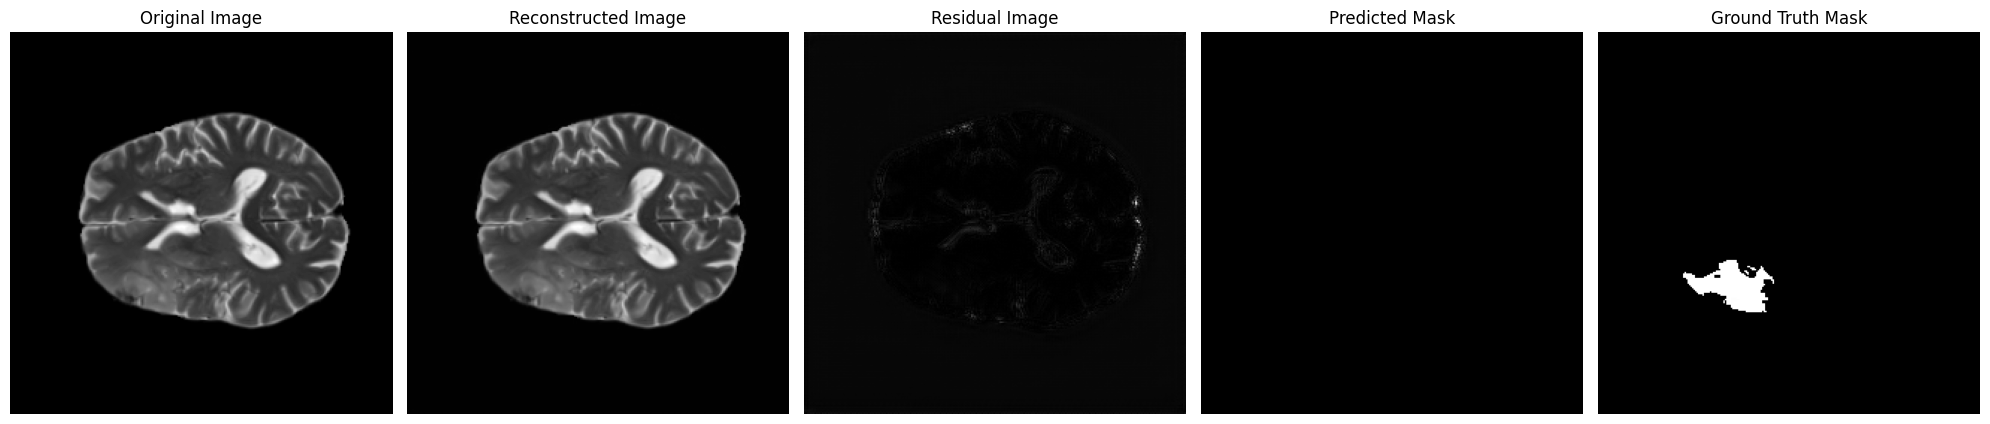

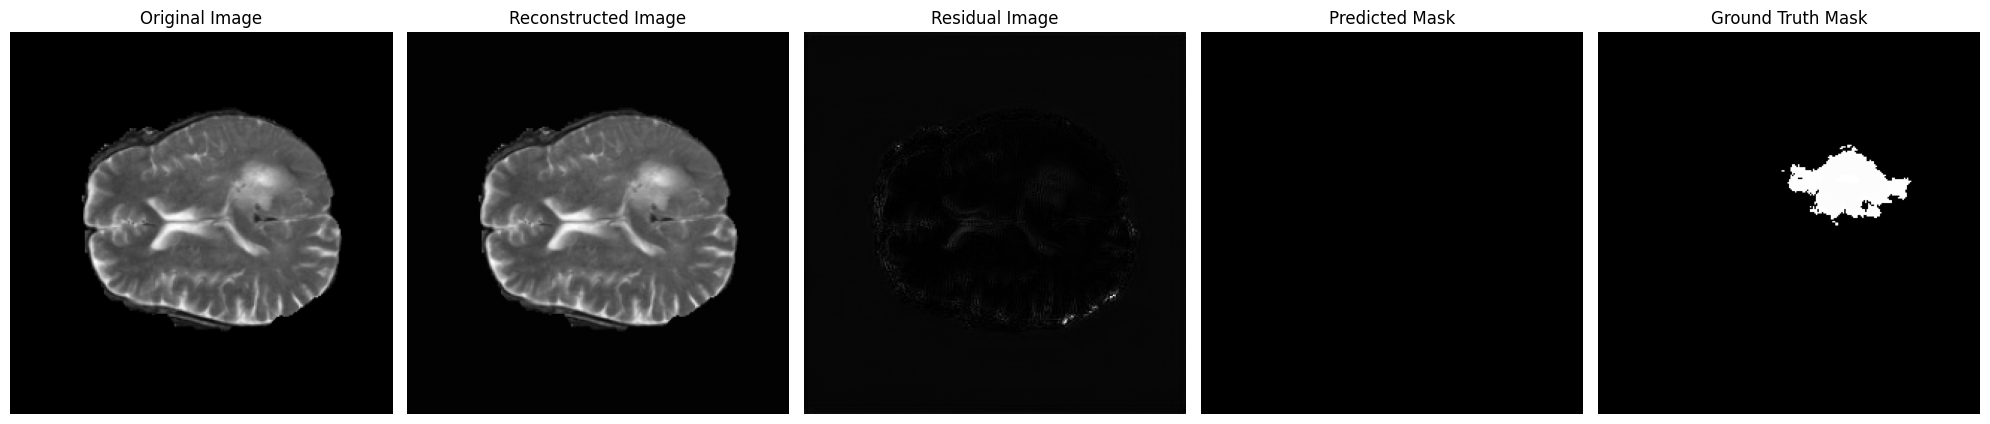

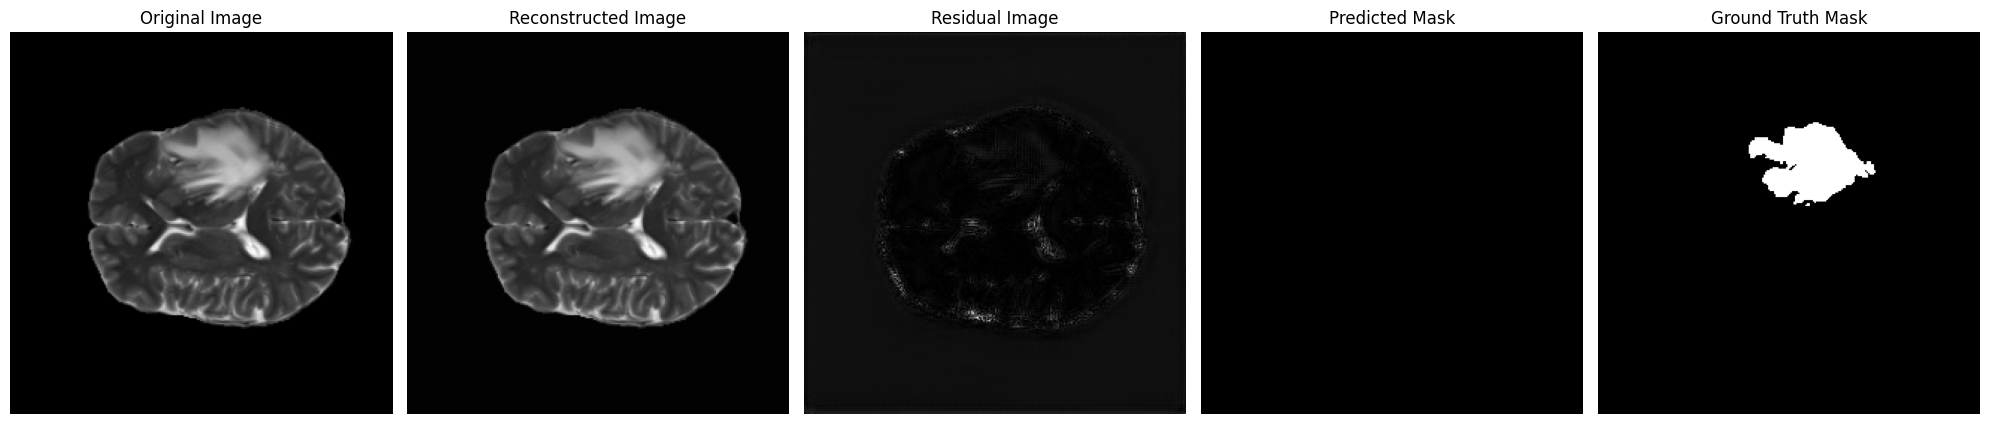

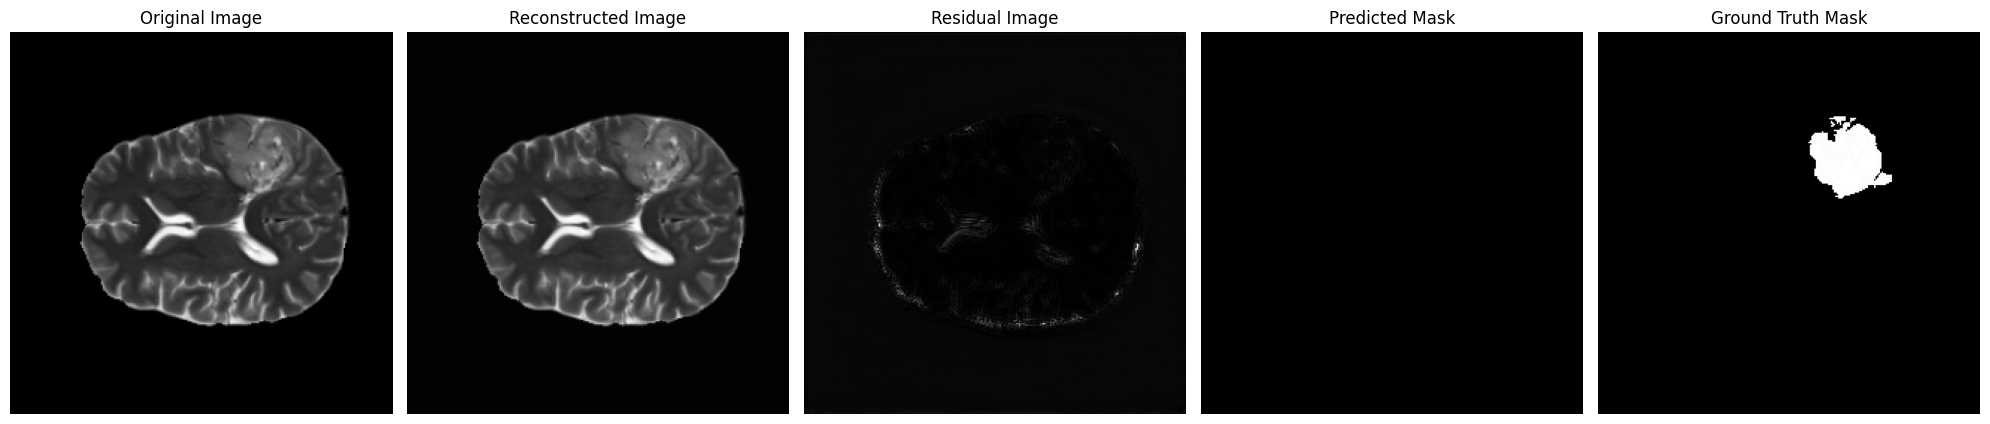

In [46]:
plot_random_results_vae(vae, brats_dataset)